# Generating Explicit Priors

In [12]:
import json
import sys, glob, os
from skimage import measure
import mesh_to_sdf as mts
import open3d as o3d
import numpy as np
from tqdm import tqdm
from stl import mesh as npmesh
import torch
import matplotlib.pyplot as plt
import trimesh

sys.path.append("../../")

In [2]:
with open('../data/splits.json', 'r') as file:
    splits = json.load(file)

In [3]:
train_pollen = splits["train"]

In [18]:
voxels = []

for vox in train_pollen:
    voxel = torch.load(os.path.join('../data/processed/voxels/', vox.split('.')[0] + '.pt'))
    voxels.append(voxel)

In [22]:
# add all voxels into a single 32x32x32 voxel grid
voxels_stacked = torch.stack(voxels, dim=0)

#ax = plt.figure().add_subplot(projection='3d')
#ax.voxels(voxels_stacked[0].numpy(), edgecolor='k')

voxels_stacked.shape

torch.Size([144, 32, 32, 32])

{(np.int64(1),
  np.int64(9),
  np.int64(9)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a783037d0>,
 (np.int64(1),
  np.int64(10),
  np.int64(8)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78329890>,
 (np.int64(1),
  np.int64(10),
  np.int64(12)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a7832ae10>,
 (np.int64(1),
  np.int64(11),
  np.int64(7)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78334310>,
 (np.int64(1),
  np.int64(11),
  np.int64(13)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78335b90>,
 (np.int64(1),
  np.int64(12),
  np.int64(6)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78337150>,
 (np.int64(1),
  np.int64(12),
  np.int64(13)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a783406d0>,
 (np.int64(1),
  np.int64(13),
  np.int64(6)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78341e10>,
 (np.int64(1),
  np.int64(13),
  np.int64(13)): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x21a78343490>

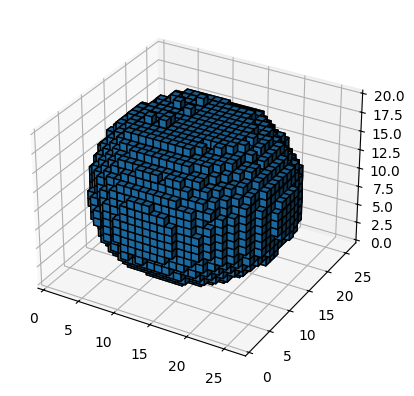

In [37]:
VOXEL_DIR = '../data/processed/voxels/'
voxels = []

for fname in train_pollen:
    base = os.path.splitext(fname)[0]
    path = os.path.join(VOXEL_DIR, base + '.pt')
    voxel = torch.load(path)
    voxels.append(voxel.float())

voxel_stack = torch.stack(voxels, dim=0)
counts = voxel_stack.sum(dim=0)

mean_voxel = voxel_stack.mean(dim=0)

N = voxel_stack.shape[0]
threshold = N / 2 # "majority vote"
mean_shape = (counts >= threshold)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(mean_shape, edgecolor='k')


In [39]:
mean_shape

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [44]:
verts, faces, normals, _ = measure.marching_cubes(mean_shape.numpy(), level=0.5)

# build a Trimesh object
mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)


In [114]:
import fast_simplification
import pyvista as pv

pv_mesh = pv.wrap(mesh)

simplified = fast_simplification.simplify_mesh(pv_mesh, target_reduction=0.9395)

len(simplified.points)

156

In [81]:
faces_as_array = simplified.faces.reshape((simplified.n_faces, 4))[:, 1:] 
tmesh = trimesh.Trimesh(simplified.points, faces_as_array) 

In [82]:
# save the mesh
tmesh.export('../notebooks/mean_pollen_shape.stl')

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x004\x01\x00\x00N\xa1~?/\xcbq\xbdT\xa5\xad=\x9a\x99y?~$FAD\\\xa9@\x1d>\x10?\xfb\x11oA\x04l>A\x00\x00\x00?q\xd4\x16AA\xe5\x0cA\x00\x00m\xc7\x7f?d@\xe9\xbct\xcf\xf7<\x00\x00\x00?q\xd4\x16AA\xe5\x0cA\x1d>\x10?\xfb\x11oA\x04l>A@\xac\xd8>\xd0W8A\x13\x08UA\x00\x00\x1c\xd8z?\x89\xc0!\xbe\xf9-\xfa=\x9a\x99y?~$FAD\\\xa9@UU\x95?\xab\xaazA\x00\x00\x00A\x1d>\x10?\xfb\x11oA\x04l>A\x00\x00\x00\xa1:?\x011/\xbf\t+l\xbcUU\x95?\xab\xaazA\x00\x00\x00A\xb8\xd7\xe1?\x1cf\x81A\x1b\xa8aA\x1d>\x10?\xfb\x11oA\x04l>A\x00\x00E\nf?cV\x89>\xc2\xc9\xb1>\xf7\x12\xda?K*\xe0@\xc1\xf9\xf1@\x9a\x99y?~$FAD\\\xa9@\x00\x00\x00?q\xd4\x16AA\xe5\x0cA\x00\x00q\xd7\x7f?\xd2S\xd7<#\x82\xbf\xbc\xab\xaa\xea?UU\xd5@z\x

In [83]:
len(tmesh.faces), len(tmesh.vertices)

(308, 156)